# P

In [ ]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as pl
import cvxopt
from cvxopt import matrix
from cvxopt import solvers

sampx = np.loadtxt('polydata_data_sampx.txt') 
sampy = np.loadtxt('polydata_data_sampy.txt')
polyx = np.loadtxt('polydata_data_polyx.txt') 
polyy = np.loadtxt('polydata_data_polyy.txt')

#10th orders
K = 5
def PHI(K,data):
    phi = []
    for i in range(0, K + 1):
        phi_inter = data ** i
        phi.append(phi_inter)
    phi = np.mat(phi)
    return phi
phisamp = PHI(K,sampx)

def plots(samp_x,samp_y,ploy_x,ploy_y,predict,label='name'):
    pl.plot(samp_x,samp_y,'bo',label='samples')
    pl.plot(ploy_x,predict,label=label)
    pl.plot(ploy_x,ploy_y,label='True function')
    pl.title(label)
    pl.legend() 
    pl.savefig(label+"-10th order.jpg")
    pl.close()
    return
def plots_BR(samp_x,samp_y,ploy_x,ploy_y,predict):
    pl.plot(samp_x,samp_y,'bo',label='samples')
    pl.plot(ploy_x,predict[0],label='function')
    pl.errorbar(ploy_x,ploy_y,np.sqrt(np.diag(predict[1])),label='True function')
    pl.title('BR-10th order')
    pl.legend()
    pl.savefig("BR-10th order.jpg")
    pl.show()

def MSE(trueoutput, learnedoutput):
    trueoutput = trueoutput.reshape(len(trueoutput),1)
    learnedoutput = learnedoutput.reshape(len(learnedoutput),1)
    return np.sum(np.square(trueoutput-learnedoutput))/np.size(trueoutput)

# outliers

In [ ]:

def set_outliesrs(n,data,times):
    outliers = np.random.randint(0,np.size(data),n)
    data[outliers] = data[outliers] * times
    return data
#set_outliers
sampy = set_outliesrs(5,sampy,10)

ls = poly_LS(phisamp,sampy)
print('Estimated parameters: ',ls)
ls_predict = np.transpose(PHI(K,polyx)) * ls
plots(sampx,sampy,polyx,polyy,ls_predict,'LS')
print(MSE(polyy,ls_predict))

rls = poly_RLS(phisamp,sampy,1)
print('Estimated parameters: ',rls)
rls_predict = np.transpose(PHI(K,polyx)) * rls
plots(sampx,sampy,polyx,polyy,rls_predict,'RLS')
print(MSE(polyy,rls_predict))

lasso = poly_LASSO(phisamp,sampy,1)
print('Estimated parameters: ',lasso)
lasso_predict = np.dot(np.transpose(PHI(K,polyx)),lasso)
plots(sampx,sampy,polyx,polyy,lasso_predict,'LASSO')
print(MSE(polyy,lasso_predict))

rr = poly_RR(phisamp,sampy)
print('Estimated parameters: ',rr)
rr_predict = np.dot(np.transpose(PHI(K,polyx)),rr)
plots(sampx,sampy,polyx,polyy,rr_predict,'RR')
print(MSE(polyy,rr_predict))

post = posterior(sampy, phisamp, 0.1, 0.1)
br = poly_BR(polyx,post[0],post[1],K)
print('Estimated parameters: ',br[0])
plots_BR(sampx,sampy,polyx,polyy,br)
print(MSE(polyy,br[0]))

# Least square

In [42]:
#LS
def poly_LS(phi,y):
    return (phi * np.transpose(phi)).I * phi * np.transpose(np.mat(y))

# Regularized LS

In [41]:
#RLS
def poly_RLS(phi,y,Labmda):
    return ((phi * np.transpose(phi) + Labmda * np.eye(np.shape(phi)[0])).I) * phi * np.transpose(np.mat(y))

# LASSO

In [40]:
#LASSO
def poly_LASSO(phi,y,Lambda):
    phiphiT = phi * np.transpose(phi)
    H = np.vstack(((np.hstack((phiphiT,-1 * phiphiT))),
              (np.hstack((-1 * phiphiT, phiphiT)))))    
    phiy = np.vstack((phi * np.transpose(np.mat(y)),-1 * phi * np.transpose(np.mat(y))))
    f = Lambda * np.ones(phiy.shape) - phiy
    G = np.eye(len(f))*-1
    h = np.zeros(len(f))
    sol = solvers.qp(matrix(H),matrix(f),matrix(G),matrix(h))
    x = sol['x']
    theta = x[:int(len(x)/2)]- x[int(len(x)/2):]
    return theta

# RR

In [95]:
#RR
def poly_RR(phi,y):
    A = np.vstack(((np.hstack((-1 * np.transpose(phi),-1*np.eye(np.shape(np.transpose(phi))[0])))),
              (np.hstack((np.transpose(phi), -1*np.eye(np.shape(np.transpose(phi))[0]))))))  
    b = np.hstack((-y,y))
    f = np.hstack((np.zeros(np.shape(np.transpose(phi))[1]),np.ones(np.shape(np.transpose(phi))[0])))
    sol = solvers.lp(matrix(f),matrix(A),matrix(b))
    theta = np.array(sol['x'][:np.shape(np.transpose(phi))[1]])   
    return theta

# Bayesian regression

In [38]:
#Bayesian regression
def posterior(y,phi,alpha,sigma):
    thelta_cov = (1/alpha * np.eye(np.shape(phi)[0]) + 1/(sigma ** 2) * phi * np.transpose(phi)).I
    thelta_mean = 1/(sigma ** 2) * thelta_cov * phi * np.transpose(np.mat(y))
    return thelta_mean,thelta_cov
def poly_BR(x,thelta_mean,thelta_cov,K):
    thelta_mean_star = np.transpose(PHI(K,x)) * thelta_mean
    thelta_cov_star = np.transpose(PHI(K,x)) * thelta_cov * thelta_cov * PHI(K,x)
    return thelta_mean_star,thelta_cov_star

# Experiment with hyperparameters

In [31]:
Lambda = np.linspace(0.1,5,15)
mse_rls = []
for i in range(0,len(Lambda)):
    rls = poly_RLS(phisamp,sampy,Lambda[i])   
    predict = np.transpose(PHI(K,polyx)) * rls    
    mse_rls.append(MSE(polyy,predict))
Lambda[mse_rls.index(min(mse_rls))]

0.45000000000000007

In [33]:
mse_lasso = []
for i in range(0,len(Lambda)):
    lasso = poly_LASSO(phisamp,sampy,Lambda[i])
    np.dot(np.transpose(PHI(K,polyx)),lasso)    
    mse_lasso.append(MSE(polyy,predict))
mse_lasso[mse_rls.index(min(mse_rls))]

     pcost       dcost       gap    pres   dres
 0: -1.0415e+03 -1.0378e+03  3e+01  6e+00  2e-03
 1: -1.0397e+03 -1.0412e+03  2e+00  1e-15  3e-16
 2: -1.0410e+03 -1.0411e+03  1e-01  4e-16  5e-16
 3: -1.0411e+03 -1.0411e+03  3e-03  4e-16  2e-16
 4: -1.0411e+03 -1.0411e+03  2e-04  3e-16  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0438e+03 -1.0333e+03  3e+01  7e+00  1e-03
 1: -1.0363e+03 -1.0404e+03  4e+00  5e-16  5e-16
 2: -1.0395e+03 -1.0398e+03  4e-01  4e-16  8e-17
 3: -1.0396e+03 -1.0396e+03  2e-02  3e-16  1e-16
 4: -1.0396e+03 -1.0396e+03  7e-04  2e-16  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0491e+03 -1.0396e+03  1e+01  8e+00  9e-17
 1: -1.0396e+03 -1.0389e+03  1e+00  7e-01  2e-16
 2: -1.0383e+03 -1.0383e+03  7e-02  3e-02  3e-16
 3: -1.0382e+03 -1.0382e+03  3e-03  3e-16  3e-16
 4: -1.0382e+03 -1.0382e+03  2e-04  4e-16  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 

0.45915793875298655

In [63]:
mu = np.linspace(1,10,10)
ceta = np.linspace(1,5,5)
mse_br = np.zeros((10,5))
for i in range(0,len(mu)):
    for j in range(0,len(ceta)):
        post = posterior(sampy, phisamp, mu[i], ceta[j])
        br = poly_BR(polyx,post[0],post[1],K)   
        mse_br[i,j] = (MSE(polyy,br[0]))
re = np.where(mse_br == np.min(mse_br))
print(mu[re[0]])
print(np.square(ceta[re[1]]))        

[ 2.  8.]
[ 1.  4.]


# Experiment with subset samples

In [135]:
mse = np.zeros((5,20))
mean_mse = np.zeros((5,5)) 
for j in range(5):   
    for i in range(20):
        X_train, X_test, y_train, y_test = train_test_split(sampx, sampy, test_size=0.8 - j * 0.2)
        phisubsamp = PHI(K,X_train)
        #LS
        ls = poly_LS(phisubsamp,y_train)
        ls_predict = np.transpose(PHI(K,polyx)) * ls
        #plots(sampx,sampy,polyx,polyy,predict,'LS')
        mse[0,i] = MSE(polyy,ls_predict)
        
        #RLS
        rls = poly_RLS(phisubsamp,y_train,0.45)
        rls_predict = np.transpose(PHI(K,polyx)) * rls
        #plots(sampx,sampy,polyx,polyy,predict,'RLS')
        mse[1,i] = MSE(polyy,rls_predict)
        #LASSO
        lasso = poly_LASSO(phisubsamp,y_train,0.46)
        lasso_predict = np.dot(np.transpose(PHI(K,polyx)),lasso)
        #plots(sampx,sampy,polyx,polyy,predict,'LASSO')
        mse[2,i] = MSE(polyy,lasso_predict)
        #RR
        rr = poly_RR(phisubsamp,y_train)
        rr_predict = np.dot(np.transpose(PHI(K,polyx)),rr)
        #plots(sampx,sampy,polyx,polyy,predict,'RR')
        mse[3,i] = MSE(polyy,rr_predict)
        #BR
        post = posterior(y_train, phisubsamp, 1, 2)
        br = poly_BR(polyx,post[0],post[1],K)
        #plots_BR(sampx,sampy,polyx,polyy,br)
        mse[4,i] = MSE(polyy,br[0])
    mean_mse[:,j] = np.mean(mse,axis=1)  

     pcost       dcost       gap    pres   dres
 0: -2.6367e+02 -2.4694e+02  6e+01  9e+00  9e-03
 1: -2.5319e+02 -2.5955e+02  6e+00  1e-15  3e-16
 2: -2.5854e+02 -2.5909e+02  5e-01  1e-15  2e-16
 3: -2.5881e+02 -2.5887e+02  7e-02  1e-15  2e-16
 4: -2.5883e+02 -2.5883e+02  1e-03  7e-16  2e-16
 5: -2.5883e+02 -2.5883e+02  1e-05  7e-16  3e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -3.5527e-15  3e+01  4e-01  8e-16  1e+00
 1:  3.8237e+00  3.8452e+00  4e+00  5e-02  2e-14  2e-01
 2:  4.5519e+00  4.5574e+00  8e-01  1e-02  8e-14  3e-02
 3:  4.7137e+00  4.7146e+00  1e-01  2e-03  9e-14  5e-03
 4:  4.7312e+00  4.7312e+00  7e-03  1e-04  1e-13  3e-04
 5:  4.7328e+00  4.7328e+00  7e-05  1e-06  2e-14  3e-06
 6:  4.7328e+00  4.7328e+00  7e-07  1e-08  7e-14  3e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -4.7061e+01 -4.3452e+01  7e+00  7e+00  1e-16
 1: -4.3582e+01 -4.3344e+01  5e-01  4e-01  2e-16
 2: -4.3215e+01 -4

 6:  2.3702e+01  2.3702e+01  6e-05  5e-07  8e-14  1e-06
 7:  2.3702e+01  2.3702e+01  6e-07  5e-09  6e-14  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -4.5308e+02 -4.4984e+02  7e+00  6e+00  1e-16
 1: -4.4989e+02 -4.4969e+02  4e-01  4e-01  2e-16
 2: -4.4951e+02 -4.4951e+02  6e-02  4e-02  3e-16
 3: -4.4948e+02 -4.4948e+02  3e-03  8e-04  1e-16
 4: -4.4948e+02 -4.4948e+02  5e-05  8e-06  3e-16
 5: -4.4948e+02 -4.4948e+02  5e-07  8e-08  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -6.6613e-16  1e+02  7e-01  7e-16  1e+00
 1:  1.5927e+01  1.6046e+01  2e+01  2e-01  2e-15  3e-01
 2:  2.1823e+01  2.1851e+01  4e+00  3e-02  3e-14  7e-02
 3:  2.2961e+01  2.2965e+01  5e-01  4e-03  2e-14  1e-02
 4:  2.3185e+01  2.3186e+01  4e-02  3e-04  5e-14  9e-04
 5:  2.3199e+01  2.3199e+01  4e-04  3e-06  9e-14  9e-06
 6:  2.3199e+01  2.3199e+01  4e-06  3e-08  1e-13  9e-08
Optimal solution found.
     pcost       dcost      

 4: -9.8660e+02 -9.8660e+02  1e-03  5e-16  8e-17
 5: -9.8660e+02 -9.8660e+02  1e-05  5e-16  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00  1.8943e-15  3e+02  9e-01  2e-15  1e+00
 1:  3.1124e+01  3.1313e+01  5e+01  2e-01  3e-15  4e-01
 2:  4.9705e+01  4.9746e+01  9e+00  3e-02  4e-15  8e-02
 3:  5.2925e+01  5.2938e+01  3e+00  9e-03  5e-14  2e-02
 4:  5.3941e+01  5.3948e+01  1e+00  4e-03  6e-14  1e-02
 5:  5.4336e+01  5.4337e+01  2e-01  6e-04  2e-13  2e-03
 6:  5.4411e+01  5.4411e+01  7e-03  2e-05  2e-13  8e-05
 7:  5.4414e+01  5.4414e+01  7e-05  2e-07  1e-13  8e-07
 8:  5.4414e+01  5.4414e+01  7e-07  2e-09  8e-14  8e-09
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0071e+03 -9.9422e+02  4e+01  8e+00  2e-03
 1: -9.9825e+02 -1.0034e+03  5e+00  8e-16  3e-16
 2: -1.0023e+03 -1.0028e+03  5e-01  7e-16  1e-16
 3: -1.0025e+03 -1.0025e+03  2e-02  4e-16  2e-16
 4: -1.0025e+03 -1.0025e+03  2e-04  4e-16  2e-16
Opt

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -2.2204e-16  3e+02  9e-01  9e-16  1e+00
 1:  3.9223e+01  3.9399e+01  6e+01  2e-01  5e-15  4e-01
 2:  5.8134e+01  5.8186e+01  1e+01  4e-02  2e-14  1e-01
 3:  6.3314e+01  6.3326e+01  2e+00  7e-03  6e-14  2e-02
 4:  6.4289e+01  6.4291e+01  4e-01  1e-03  9e-14  3e-03
 5:  6.4452e+01  6.4452e+01  7e-02  2e-04  4e-14  6e-04
 6:  6.4483e+01  6.4483e+01  3e-03  8e-06  4e-14  2e-05
 7:  6.4484e+01  6.4484e+01  3e-05  8e-08  1e-13  2e-07
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0440e+03 -1.0332e+03  3e+01  7e+00  1e-03
 1: -1.0363e+03 -1.0404e+03  4e+00  9e-16  8e-17
 2: -1.0394e+03 -1.0398e+03  4e-01  6e-16  2e-16
 3: -1.0395e+03 -1.0396e+03  2e-02  1e-16  3e-16
 4: -1.0396e+03 -1.0396e+03  7e-04  2e-16  3e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00  1.8804e-15  3e+02  9e-01  2e-15  1e+00
 1:  3.9223e+01  3.9399e+01  6e+01  2e-01  4e-1

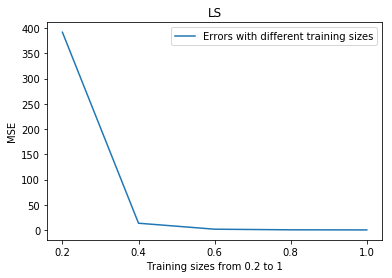

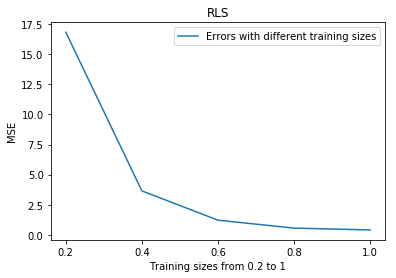

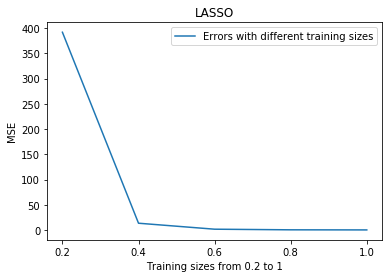

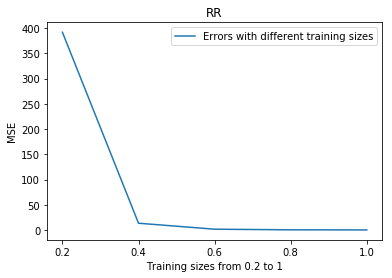

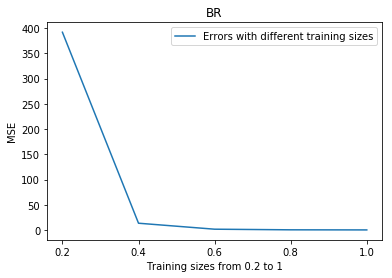

In [143]:
plots_msesub(mean_mse[0,:],"LS")
plots_msesub(mean_mse[1,:],"RLS")
plots_msesub(mean_mse[0,:],"LASSO")
plots_msesub(mean_mse[0,:],"RR")
plots_msesub(mean_mse[0,:],"BR")